In [1]:
import torch
import os
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from torchvision import datasets
from tqdm import tqdm
os.chdir('../src')

from models.diffusion import Diffusion, CondDiffusion
from models.unet import Unet
from models.condunet import condUnet

reverse_transform = transforms.Compose([transforms.Lambda(lambda x: (x+1)/2), transforms.ToPILImage()])


In [2]:
os.makedirs('../data/CIFAR10', exist_ok=True)

dataset_train = datasets.CIFAR10(
        root='../data/CIFAR10',
        train=True,
        download=True,
        transform=transforms.Compose([transforms.Grayscale(), transforms.CenterCrop(28),transforms.ToTensor()])
    )


Files already downloaded and verified


In [5]:
model_path = '../outputs/models/fashion_mnist_diffusion_epoch_4.pt'

# model params
device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps')
data_shape = (28, 28)
channels = 1
dim_mults = (1, 2, 4, )
T = 300

net = Unet(
    dim=data_shape[0],
    channels=channels,
    dim_mults=dim_mults,
)
net.load_state_dict(torch.load(model_path))

fashion_mnist_diffusion = Diffusion(
    model=net,
    data_shape=data_shape,
    noise_schedule='linear',
    T=T,
    device=device,
)

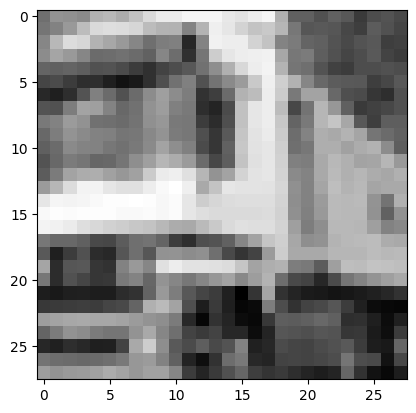

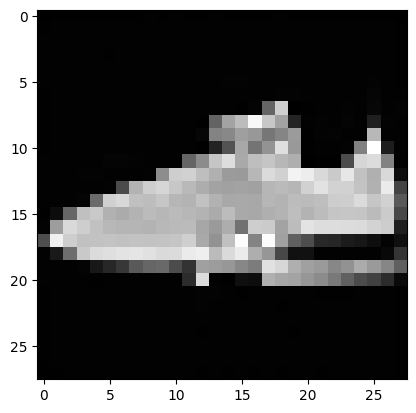

In [6]:
### Adversarial attacks via backpropagation ###
os.makedirs('../outputs/adversary', exist_ok=True)
y_0 = torch.tensor([0], device='mps')

# y_1 = torch.tensor([1], device='mps')
deterministic=False

noises = fashion_mnist_diffusion.explicit_sample(y_0)
# adversarial_target = fashion_mnist_diffusion.sample(y_1).squeeze(0)

adversarial_target = dataset_train[1][0].to("mps")

# # plot the adversarial target
plt.figure()
plt.imshow(reverse_transform(adversarial_target.cpu()), cmap='gray')
plt.savefig('../outputs/adversary/adversarial_target.png')
# # plot original image
plt.figure()
plt.imshow(reverse_transform(noises[-1].squeeze(0).cpu()), cmap='gray')
plt.savefig('../outputs/adversary/original.png')

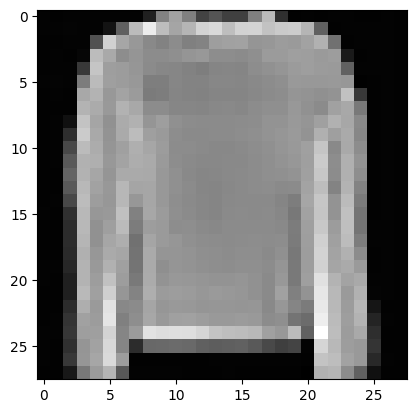

In [18]:
t = 250
latent_noise = noises[fashion_mnist_diffusion.T - t]

loss = torch.norm(noises[-1] - adversarial_target)
grad = torch.autograd.grad(loss, latent_noise)[0]

eps = 1e-2

for j in range(5):
    perturbed_latent = latent_noise - j * eps * grad
    x_t = perturbed_latent
    for i in reversed(range(0, t)):
        t_cur = torch.tensor([i], device='mps')
        x_t = fashion_mnist_diffusion.sample_p_t_grad(x_t, t_cur, deterministic=deterministic)
    image = reverse_transform(x_t.squeeze(0).cpu())
    plt.imshow(image, cmap='gray')
    plt.savefig(f'../outputs/adversary/decoded_adversarial_perturbation_t_{t}_eps_{j * eps}.png')

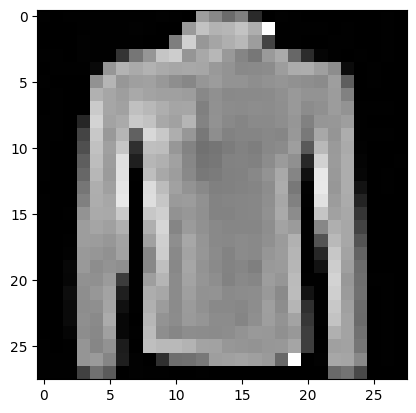

In [17]:
### Decoding from latent noise ###
os.makedirs('../outputs/latent_noise', exist_ok=True)
for t in range(0, 300, 50):
    y_0 = torch.tensor([0], device='mps')

    noise = torch.randn(1, 1, 28, 28).to(device)
    x_t = noise
    for i in reversed(range(0, t)):
        t_cur = torch.tensor([i], device='mps')
        x_t = fashion_mnist_diffusion.sample_p_t(x_t, t_cur)

    image = reverse_transform(x_t.squeeze(0).cpu())
    plt.imshow(image, cmap='gray')
    plt.savefig(f'../outputs/latent_noise/decoded_latent_noise_t_{t}.png')

In [15]:
### Adversarial attacks via latent space interpolation ###
os.makedirs('../outputs/adversary', exist_ok=True)
y_0 = torch.tensor([0], device='mps')
y_1 = torch.tensor([1], device='mps')
deterministic=False

noises = fashion_mnist_diffusion.explicit_sample(y_0)

adversarial_target = fashion_mnist_cond_diffusion.sample(y_1).squeeze(0)

NameError: name 'fashion_mnist_cond_diffusion' is not defined